# Projet IA - MA - BC - VM - 2024

## Importation

In [59]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random

from PIL import Image, ImageFilter, ImageEnhance

from sklearn.metrics import confusion_matrix
import seaborn as sns

## Chargement de la dataset

In [8]:
df_train = pd.read_csv('../../data/sign_mnist_train.csv')
df_test = pd.read_csv('../../data/sign_mnist_test.csv')

df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [9]:
y_train = df_train['label'].values
X_train = df_train.drop('label', axis=1).values

y_test = df_test['label'].values
X_test = df_test.drop('label', axis=1).values

In [10]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [11]:
# Nous devons redimensionner les données pour les passer dans le réseau de neurones convolutif
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# charge les données dans le DataLoader de PyTorch
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

### Visualisation de la répartition des données

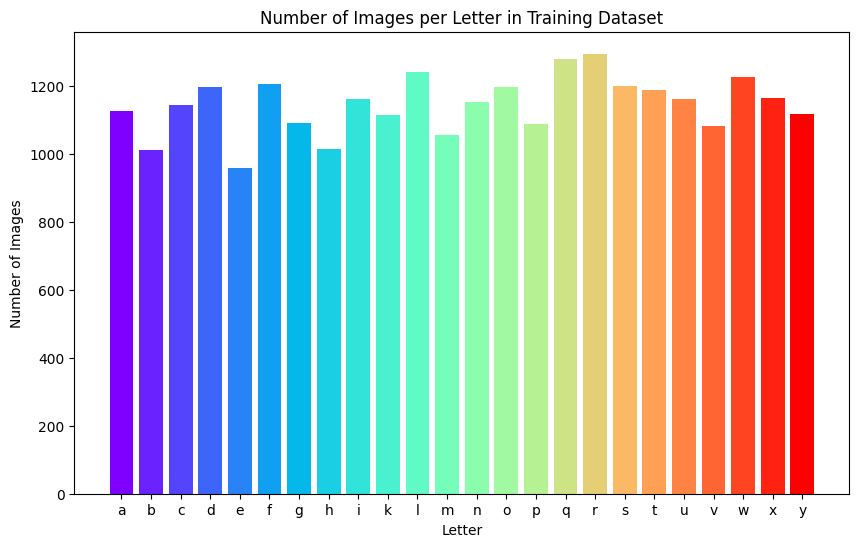

In [12]:
# Visualisation du nombre d'image par classe dans le jeu d'entraînement
letter_counts = {}
for label in y_train:
    letter = chr(label.item() + 97)  # Convertir le label en lettre (97 est le code ASCII pour 'a')
    if letter in letter_counts:
        letter_counts[letter] += 1
    else:
        letter_counts[letter] = 1

sorted_letters = sorted(letter_counts.keys())

# Créer l'histogramme
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(sorted_letters)))
plt.bar(sorted_letters, [letter_counts[letter] for letter in sorted_letters], color=colors)
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in Training Dataset')
plt.show()


## Fonction d'évaluation et d'entrainement

### Evaluation

In [13]:
def evaluate(model, test_loader):
    model.eval()  # Met le modèle en mode évaluation
    correct = 0 
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():  # Désactive la traçabilité des gradients
        for test_imgs, test_labels in test_loader:
            test_imgs = test_imgs.float()
            output = model(test_imgs)
            predicted = torch.max(output, 1)[1]
            correct += (predicted == test_labels).sum().item()
            total += test_labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())
    accuracy = 100 * correct / total
    print("Test accuracy: {:.3f}%".format(accuracy))
    return accuracy, all_labels, all_preds

### Entrainement

In [14]:
def fit(model, train_loader, test_loader, epochs=15, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}
    
    model.train()
    for epoch in range(epochs):
        correct = 0
        running_loss = 0.0
        for batch_id, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.float()
            y_batch = y_batch

            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compte le nombre de prédictions correctes
            prediction = torch.max(output.data, 1)[1]
            correct += (prediction == y_batch).sum().item()

            if batch_id % 50 == 0:
                accuracy_value = 100. * correct / ((batch_id + 1) * train_loader.batch_size)
                print(f'Epoch: {epoch} [{batch_id * len(X_batch)}/{len(train_loader.dataset)} ({100. * batch_id / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tAccuracy: {accuracy_value:.3f}%')

        # Calcul de la précision et de la perte moyenne sur une époque
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_accuracy)

        # Évaluation sur le jeu de données de test
        test_accuracy = evaluate(model)
        history['test_acc'].append(test_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.3f}%')

    return history

## Augmentation des données

In [10]:
data_transforms = v2.Compose([
    v2.RandomRotation(degrees=10),
    #v2.RandomPerspective(distortion_scale=0.2),
    v2.RandomHorizontalFlip(p=0.5), 
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Zoom et translation aléatoires
    #v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485], std=[0.225])
])

In [11]:
percentage_of_augmented_data = 100 # 100 to double the amount of data
random_integers = random.sample(range(torch_X_train.size()[0]), int((percentage_of_augmented_data)/100*torch_X_train.size()[0]))


# Créer une liste pour stocker les nouveaux objets
new_images = []
new_labels = []

# Parcourir les indices aléatoires
for i in random_integers:
    img = torch_X_train[i]
    transformed_img = data_transforms(img)
    
    # Ajouter l'image transformée à la liste
    new_images.append(transformed_img.unsqueeze(0))
    
    # Ajouter l'étiquette correspondante à la liste
    new_labels.append(torch_y_train[i].unsqueeze(0))

print(torch_X_train.size())
# Concaténer les nouvelles images et étiquettes avec les données d'origine
if new_images:
    new_images = torch.cat(new_images, dim=0)
    new_labels = torch.cat(new_labels, dim=0)

    torch_X_train = torch.cat((torch_X_train, new_images), dim=0)
    torch_y_train = torch.cat((torch_y_train, new_labels), dim=0)

print(torch_X_train.size())

torch.Size([27455, 1, 28, 28])
torch.Size([54910, 1, 28, 28])


In [57]:
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)

## Modèle de convolution

In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 75, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(75, 50, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout2d(p=0.2)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(50, 25, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(25*3*3, 512)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(512, 25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)
        
        x = x.view(-1, 25*3*3)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Création de l'instance du modèle
cnn = ConvNet()
print(cnn)

ConvNet(
  (conv1): Conv2d(1, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(75, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=225, out_features=512, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=25, bias=True)
)


## Entrainement du modèle

In [59]:
history = fit(cnn,train_loader,test_loader)

Epoch: 0 [0/54910 (0%)]	Loss: 3.330493	Accuracy: 0.000%
Epoch: 0 [1600/54910 (3%)]	Loss: 2.576744	Accuracy: 11.581%
Epoch: 0 [3200/54910 (6%)]	Loss: 1.800986	Accuracy: 24.319%
Epoch: 0 [4800/54910 (9%)]	Loss: 1.636420	Accuracy: 33.692%
Epoch: 0 [6400/54910 (12%)]	Loss: 1.365178	Accuracy: 41.231%
Epoch: 0 [8000/54910 (15%)]	Loss: 0.788972	Accuracy: 46.738%
Epoch: 0 [9600/54910 (17%)]	Loss: 1.069294	Accuracy: 50.748%
Epoch: 0 [11200/54910 (20%)]	Loss: 0.772177	Accuracy: 54.336%
Epoch: 0 [12800/54910 (23%)]	Loss: 1.040561	Accuracy: 57.248%
Epoch: 0 [14400/54910 (26%)]	Loss: 0.663731	Accuracy: 60.193%
Epoch: 0 [16000/54910 (29%)]	Loss: 0.620048	Accuracy: 62.269%
Epoch: 0 [17600/54910 (32%)]	Loss: 0.753451	Accuracy: 64.014%
Epoch: 0 [19200/54910 (35%)]	Loss: 0.524193	Accuracy: 65.651%
Epoch: 0 [20800/54910 (38%)]	Loss: 0.369106	Accuracy: 67.185%
Epoch: 0 [22400/54910 (41%)]	Loss: 0.302349	Accuracy: 68.661%
Epoch: 0 [24000/54910 (44%)]	Loss: 0.190868	Accuracy: 69.815%
Epoch: 0 [25600/54910 (

## Evaluation du modèle

In [18]:
evaluate(cnn,test_loader)

Test accuracy: 99.414%


(99.4143892916899,
 [6,
  5,
  10,
  0,
  3,
  21,
  10,
  14,
  3,
  7,
  8,
  8,
  21,
  12,
  7,
  4,
  22,
  0,
  7,
  7,
  2,
  0,
  21,
  4,
  10,
  15,
  2,
  15,
  7,
  1,
  7,
  8,
  13,
  19,
  3,
  21,
  13,
  3,
  18,
  14,
  15,
  23,
  8,
  15,
  14,
  5,
  17,
  4,
  19,
  13,
  20,
  22,
  20,
  5,
  16,
  16,
  21,
  4,
  7,
  22,
  10,
  13,
  11,
  22,
  2,
  10,
  1,
  4,
  18,
  4,
  20,
  6,
  15,
  4,
  3,
  20,
  15,
  11,
  2,
  2,
  17,
  2,
  7,
  21,
  23,
  7,
  12,
  17,
  24,
  14,
  2,
  1,
  7,
  23,
  8,
  5,
  0,
  0,
  19,
  21,
  8,
  4,
  2,
  20,
  16,
  1,
  15,
  14,
  2,
  6,
  12,
  5,
  0,
  24,
  2,
  19,
  14,
  24,
  16,
  10,
  4,
  8,
  8,
  12,
  12,
  8,
  6,
  21,
  4,
  15,
  11,
  21,
  2,
  15,
  23,
  23,
  4,
  21,
  22,
  3,
  15,
  18,
  7,
  17,
  21,
  6,
  1,
  6,
  10,
  5,
  4,
  21,
  3,
  21,
  14,
  23,
  2,
  10,
  7,
  5,
  14,
  21,
  8,
  4,
  18,
  23,
  13,
  3,
  6,
  8,
  13,
  15,
  4,
  16,
  3,
  17,
  18,
  

avec le modèle ConvNet et batch à 32 (sans data augmentation): test accuracy : 0.958%   
avec le modèle ConvNet et batch à 128 (sans data augmentation): test accuracy : 0.929%  
avec le modèle ConvNet et batch à 32 (avec data augmentation): test accuracy : 0.983%

Sauvgarder le modèle

In [75]:
#torch.save(cnn, "../save/m1.pth")

Charger le modèle

In [17]:
cnn = torch.load("../save/m1.pth")

## Résultats

### Matrice de confusion

In [35]:
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test accuracy: 99.414%


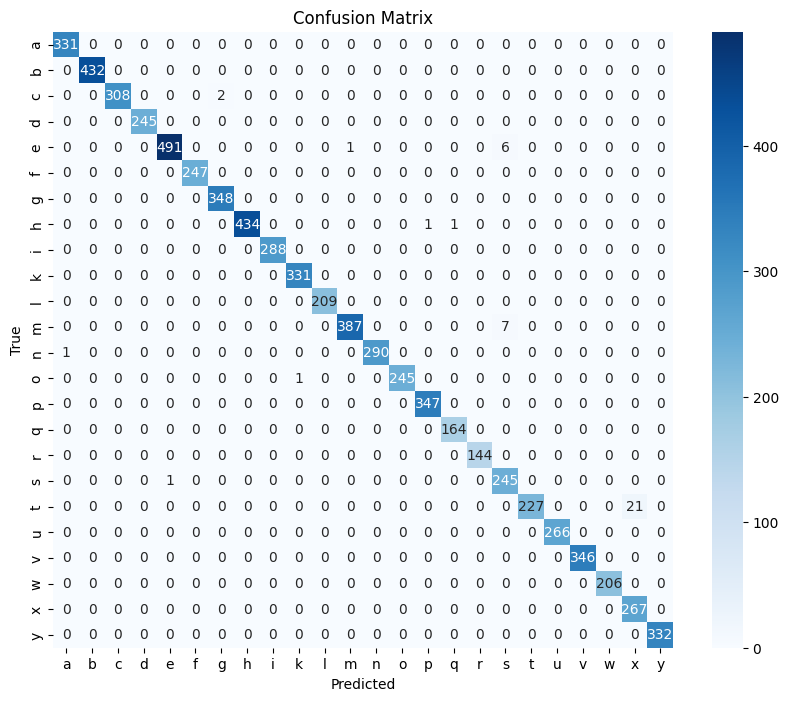

In [96]:
# Évaluation du modèle et récupération des prédictions
accuracy, all_labels, all_preds = evaluate(cnn, test_loader)

# Affichage de la matrice de confusion
class_names = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
plot_confusion_matrix(all_labels, all_preds, class_names)


### Affichage des images mal référencées

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


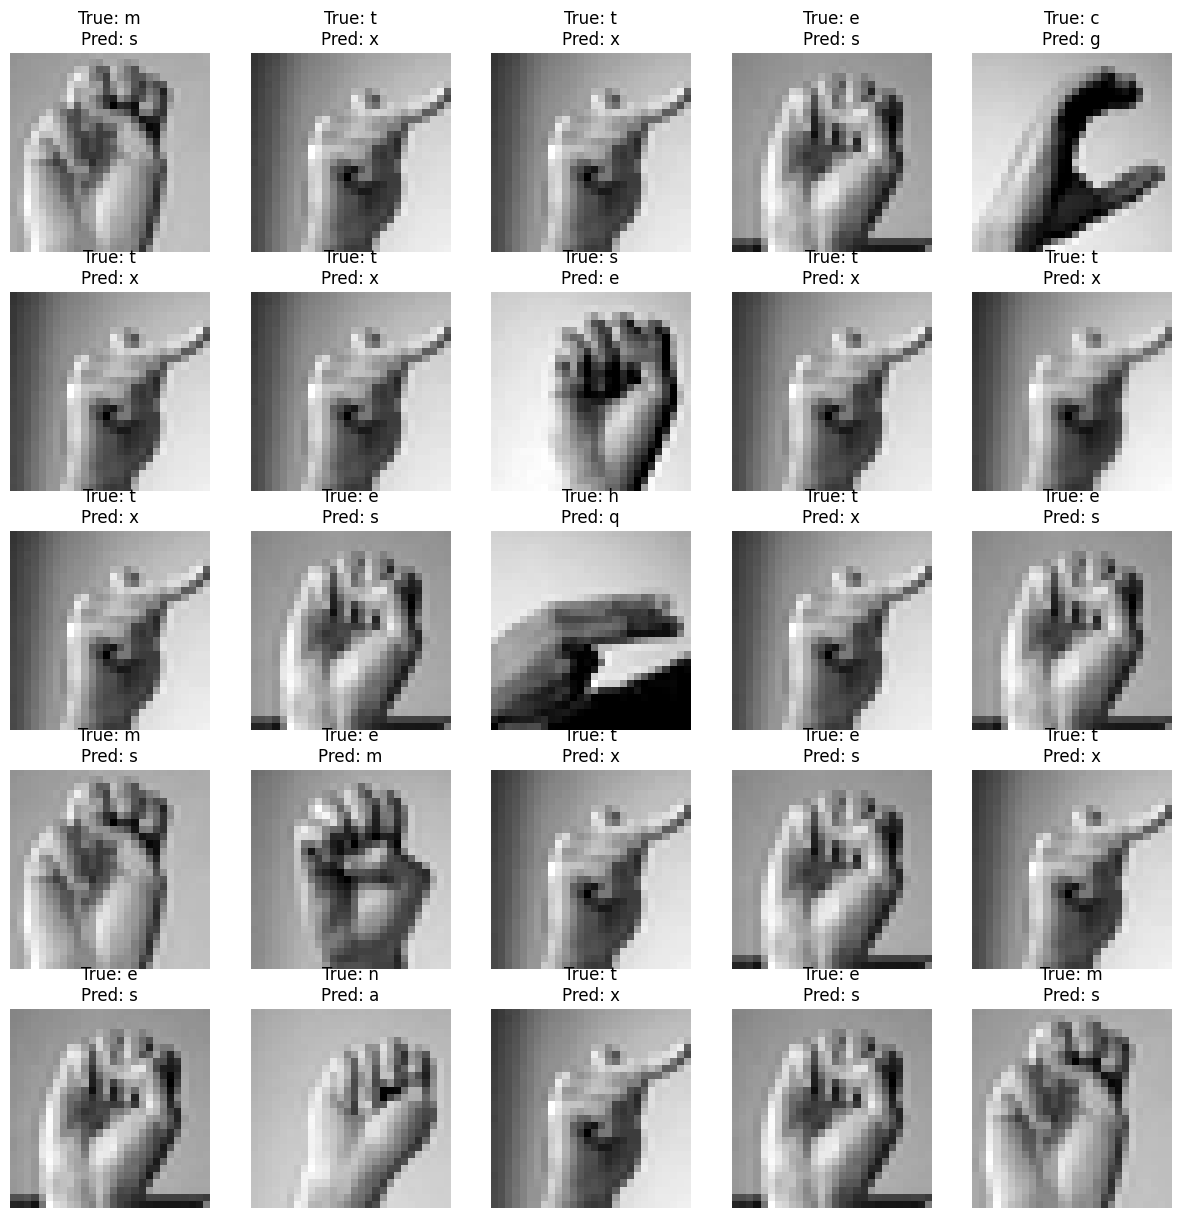

In [104]:
def plot_images_with_labels(test_loader,labels, preds, class_names = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'], num_images=10, num_rows=2):
    num_cols = (num_images + num_rows - 1) // num_rows
    plt.figure(figsize=(15, 15))
    num_images_index = 1
    for i in range(len(preds)):
        if(preds[i] != labels[i]):
            plt.subplot(num_rows, num_cols, num_images_index)
            plt.imshow(test_loader.dataset.tensors[0][i].squeeze(), cmap='gray')
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
            plt.axis('off')
            num_images_index += 1
        if(num_images_index > num_images):
            break
    plt.show()

unique_labels = set(all_labels)
print(unique_labels)

plot_images_with_labels(test_loader, all_labels, all_preds, num_images=25, num_rows=5)

### Affichage des masques de convolution

In [39]:
# Fonction pour afficher les poids des filtres
def visualize_conv_weights(weights, title):
    n_filters = weights.shape[0]
    n_channels = weights.shape[1]
    
    # Calcul de la disposition de la grille
    grid_size = int(np.ceil(np.sqrt(n_filters)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            img = weights[i, 0].detach().numpy()
            img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalisation
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Masquer les axes inutilisés
    plt.show()

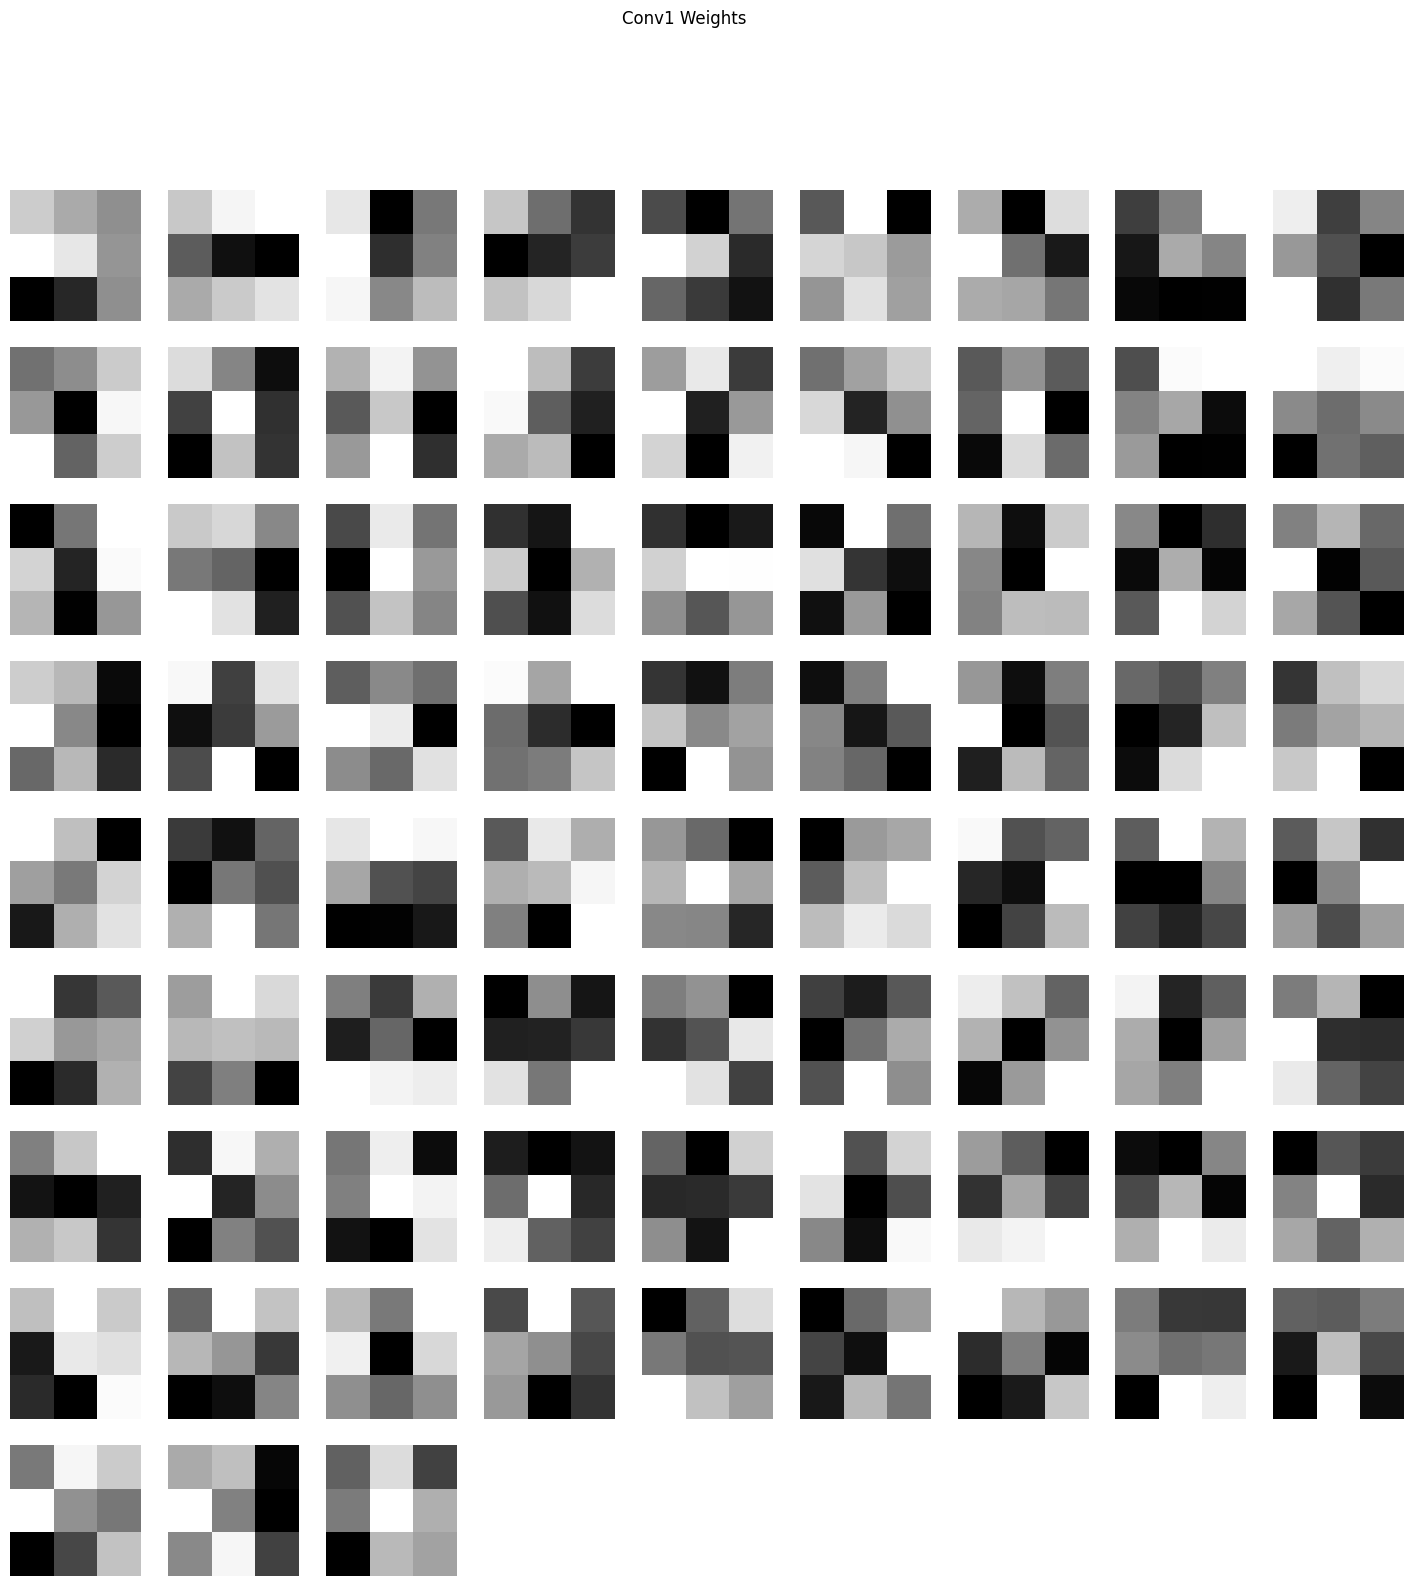

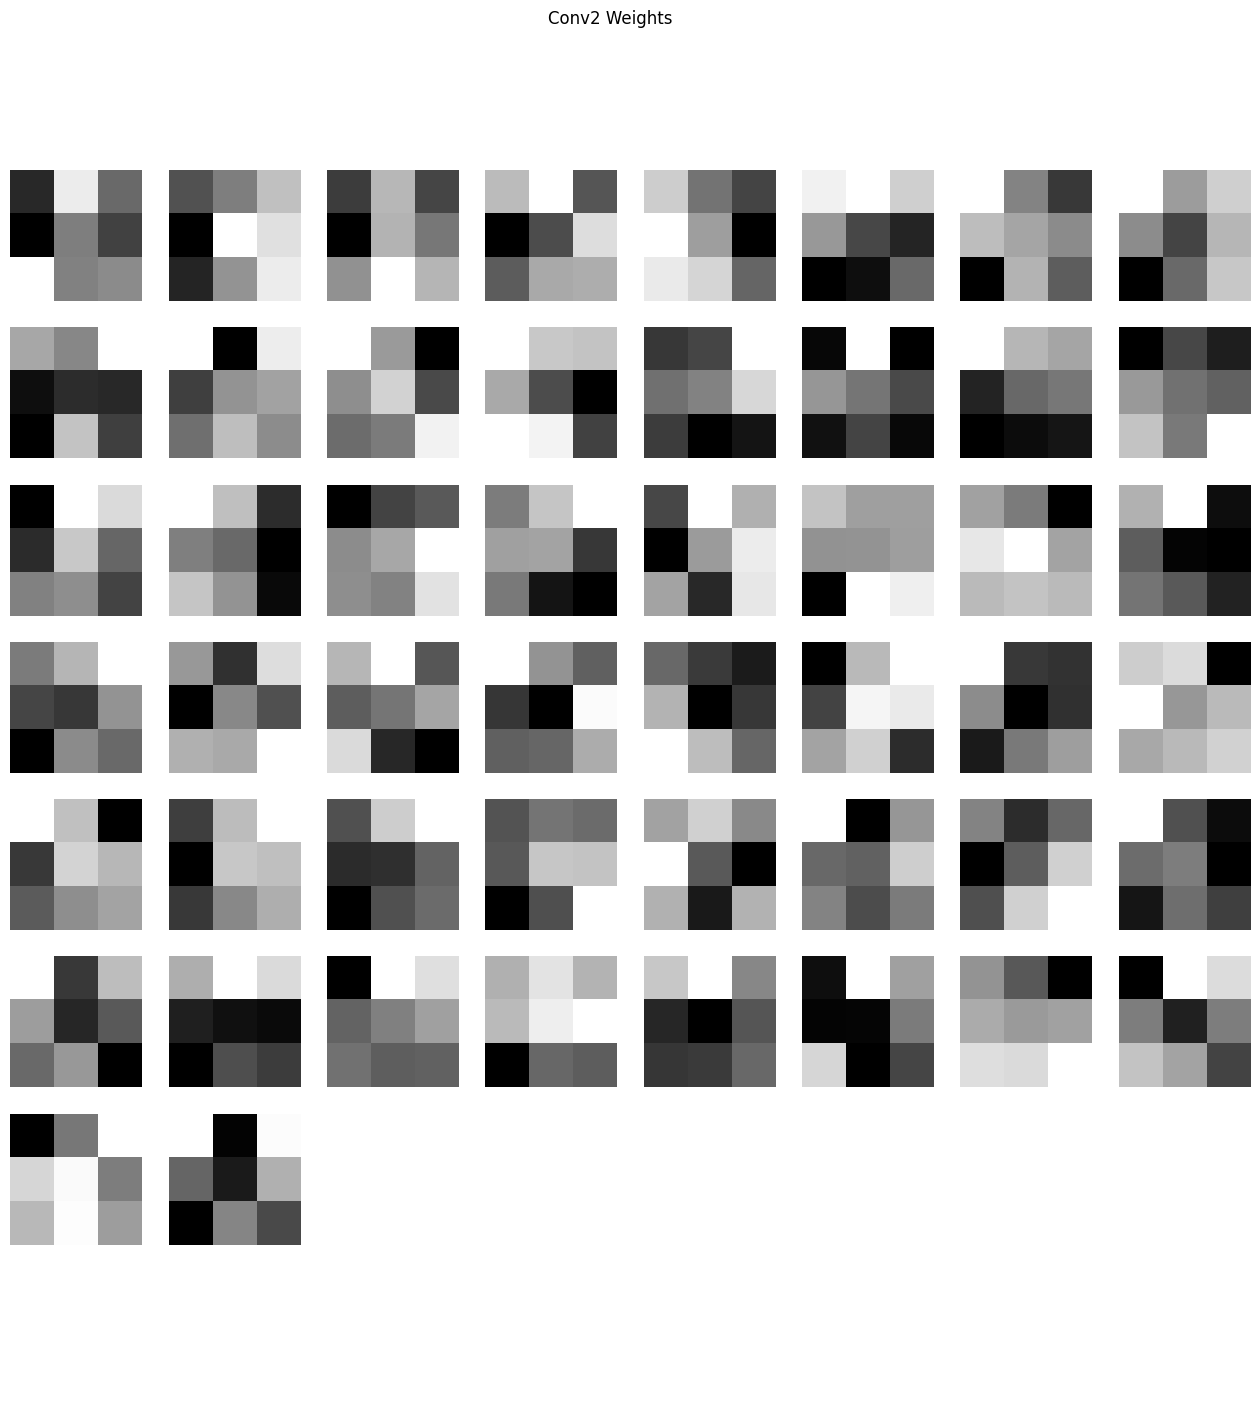

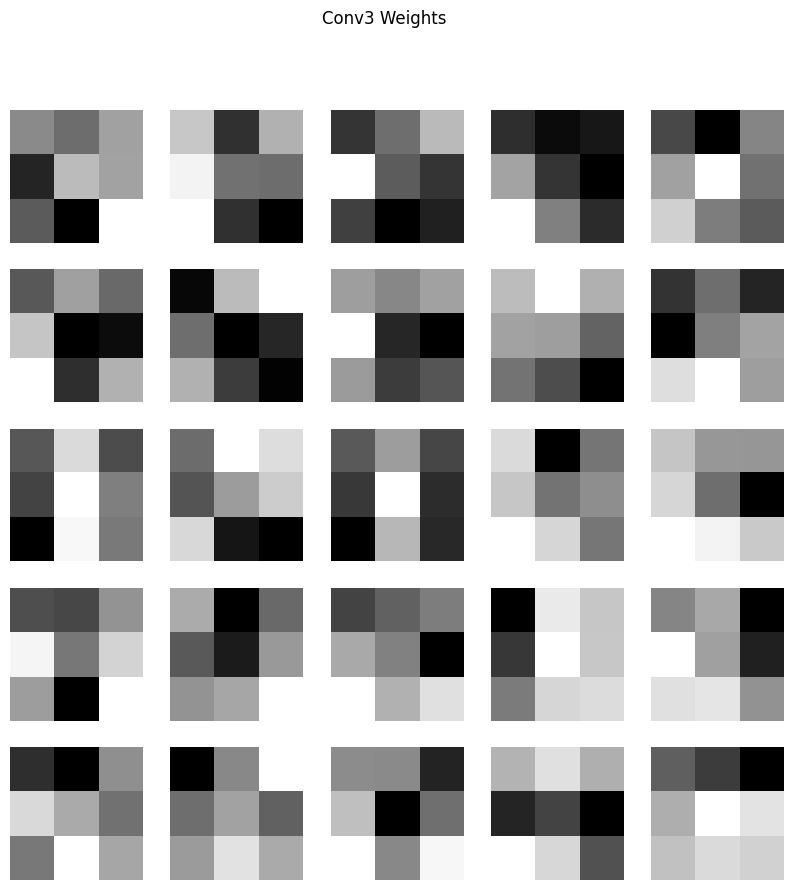

In [40]:
# Affichage des poids des filtres de la première couche de convolution
conv1_weights = cnn.conv1.weight
visualize_conv_weights(conv1_weights, "Conv1 Weights")
# Affichage des poids des filtres de la 2e couche de convolution
conv2_weights = cnn.conv2.weight
visualize_conv_weights(conv2_weights, "Conv2 Weights")
# Affichage des poids des filtres de la 3e couche de convolution
conv3_weights = cnn.conv3.weight
visualize_conv_weights(conv3_weights, "Conv3 Weights")

### Affichage de la précisions en fonction des Epochs

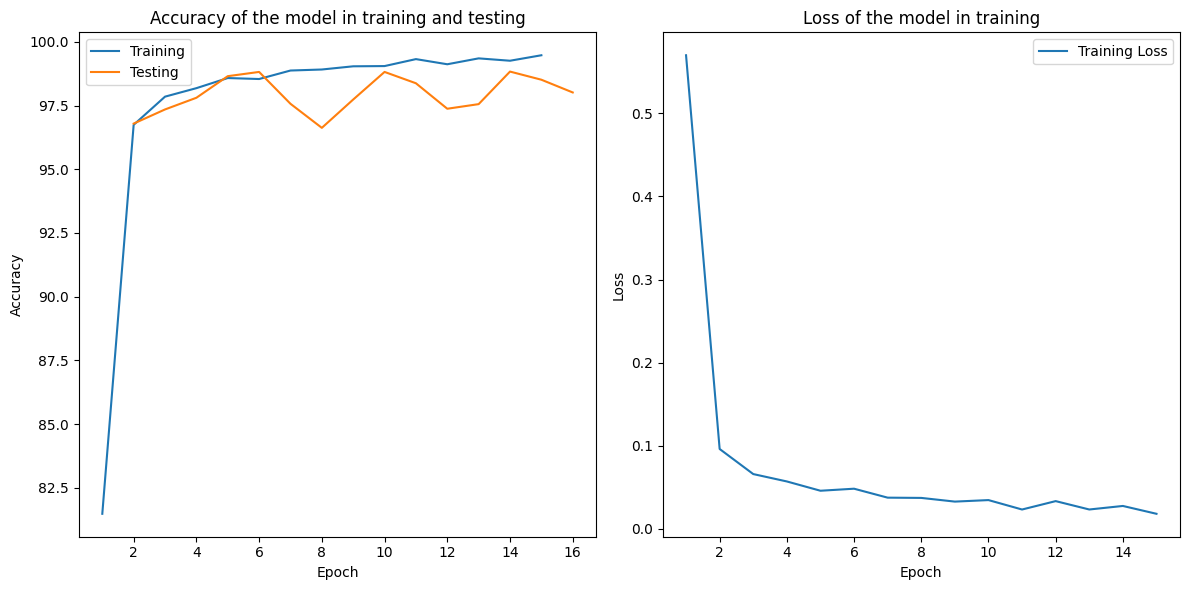

In [70]:
def plot_performance(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['train_acc'], label='Training')
    plt.plot(range(2, epochs+2), history['test_acc'], label='Testing')
    plt.title('Accuracy of the model in training and testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), history['train_loss'], label='Training Loss')
    plt.title('Loss of the model in training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_performance(history)


## Test du modèle avec nos propres images

Predicted class: 20


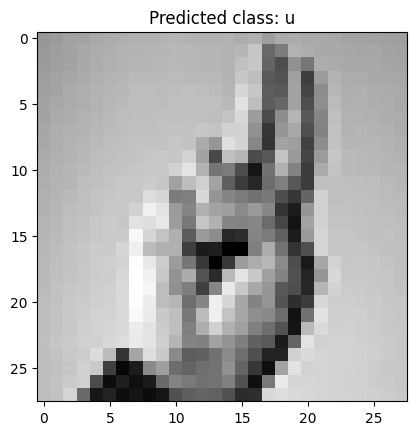

In [102]:
# Prétraitement de l'image
class EdgeEnhance:
    def __call__(self, img):
        return img.filter(ImageFilter.EDGE_ENHANCE)
    
class ReduceContrast:
    def __init__(self, factor=0.001):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        return enhancer.enhance(self.factor)

transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    EdgeEnhance(),
    v2.Resize((28, 28), ),
    ReduceContrast(factor=0.9),
    v2.ToTensor(),
    v2.Normalize((0.5,), (0.5,))
])

def load_image(image_path):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Ajouter une dimension pour le batch
    return image

# Charger et prétraiter l'image de test
image_path = '../../data/ours/test/test11.jpg'
image = load_image(image_path)
image = test_loader.dataset.tensors[0][50].unsqueeze(0)
# Faire une prédiction
output = cnn(image)
_, predicted = torch.max(output, 1)

# Afficher le résultat
print(f'Predicted class: {predicted.item()}')

# Optionnel : afficher l'image
class_names = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Predicted class: {class_names[predicted.item()]}')
plt.show()